Optimized Portfolio Weights:
    Stock    Weight
18    WMT  0.359383
29     SO  0.142449
24     GE  0.136759
8     JPM  0.105800
2    NVDA  0.104994
16     PG  0.036629
11      V  0.028610
3   GOOGL  0.026981
0    AAPL  0.019422
12   AMZN  0.013879
6     UNH  0.009117
20    XOM  0.005980
4     JNJ  0.005354
17     KO  0.003946
15    MCD  0.000698
1    MSFT  0.000000
10     GS  0.000000
9     BAC  0.000000
5     PFE  0.000000
7    MRNA  0.000000
19     UL  0.000000
14    NKE  0.000000
13   TSLA  0.000000
22     BP  0.000000
23    NEE  0.000000
25    CAT  0.000000
26     BA  0.000000
21    CVX  0.000000
27    HON  0.000000
28    DUK  0.000000
30    AMT  0.000000
31    SPG  0.000000
32      O  0.000000
33    FCX  0.000000
34    DOW  0.000000
35    LIN  0.000000

Portfolio Performance:
Expected Annual Return: 0.4519
Annual Volatility: 0.1182
Sharpe Ratio: 3.7399

--- Comparison with Traditional Optimization ---

Traditional Optimization Results:
Expected Annual Return: 0.4772
Annual Volati

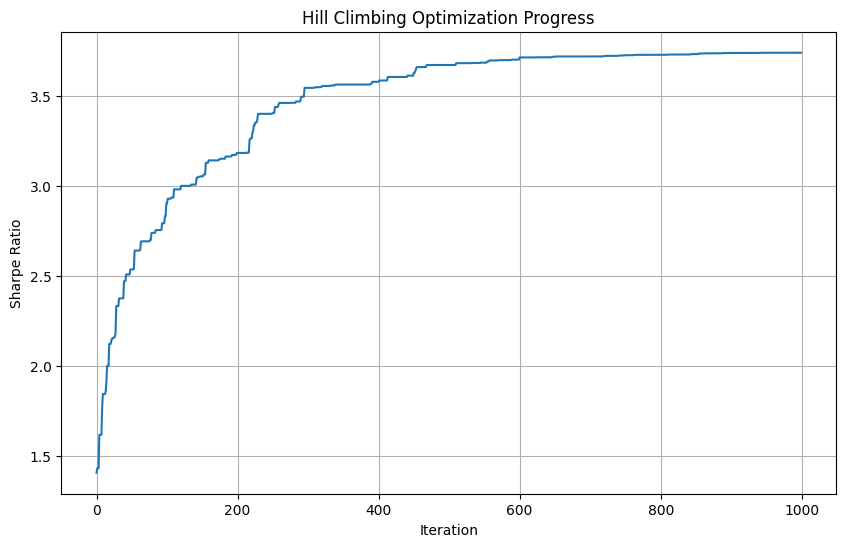

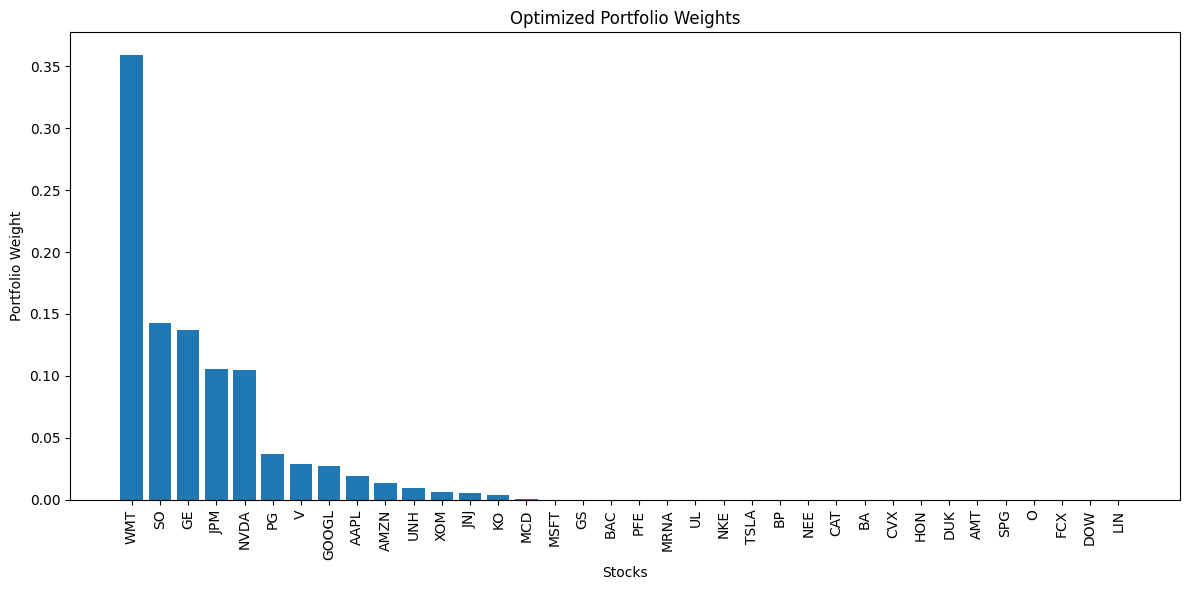

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

# Define the stock sectors (for reference)
stocks = {
    "Technology": ["AAPL", "MSFT", "NVDA", "GOOGL"],
    "Healthcare": ["JNJ", "PFE", "UNH", "MRNA"],
    "Financials": ["JPM", "BAC", "GS", "V"],
    "Consumer Discretionary": ["AMZN", "TSLA", "NKE", "MCD"],
    "Consumer Staples": ["PG", "KO", "WMT", "UL"],
    "Energy": ["XOM", "CVX", "BP", "NEE"],
    "Industrials": ["GE", "CAT", "BA", "HON"],
    "Utilities": ["DUK", "SO"],
    "Real Estate": ["AMT", "SPG", "O"],
    "Materials": ["FCX", "DOW", "LIN"]
}

# Flatten stocks dictionary to get all stock symbols
all_stocks = [stock for sector in stocks.values() for stock in sector]

# Load the data from CSV
df = pd.read_csv('close_prices.csv')
df.set_index('Date', inplace=True)

# Calculate daily returns
returns = df.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Function to calculate portfolio performance metrics
def calculate_portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.sum(mean_returns * weights) * 252  # Annualized return
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return {
        'return': portfolio_return,
        'volatility': portfolio_std_dev,
        'sharpe_ratio': sharpe_ratio
    }

# Objective function (negative Sharpe ratio - we want to maximize Sharpe ratio)
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    return -calculate_portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)['sharpe_ratio']

# Function to generate random weights that sum to 1
def generate_random_weights(n_assets):
    weights = np.random.random(n_assets)
    return weights / np.sum(weights)

# Generate small random adjustments to weights while ensuring they sum to 1
def generate_neighbor(weights, step_size=0.05):
    n_assets = len(weights)
    
    # Choose two random assets to adjust
    i, j = random.sample(range(n_assets), 2)
    
    # Generate a random adjustment within the step size
    adjustment = random.uniform(-step_size, step_size)
    
    # Create new weights by adjusting the selected assets
    new_weights = weights.copy()
    new_weights[i] += adjustment
    new_weights[j] -= adjustment
    
    # Make sure weights stay between 0 and 1
    new_weights = np.clip(new_weights, 0, 1)
    
    # Re-normalize to ensure they sum to 1
    new_weights = new_weights / np.sum(new_weights)
    
    return new_weights

# Hill Climbing algorithm for portfolio optimization
def hill_climbing(mean_returns, cov_matrix, max_iterations=1000, step_size=0.05, risk_free_rate=0.01):
    n_assets = len(mean_returns)
    
    # Start with a random portfolio
    current_weights = generate_random_weights(n_assets)
    current_sharpe = calculate_portfolio_performance(current_weights, mean_returns, cov_matrix, risk_free_rate)['sharpe_ratio']
    
    best_weights = current_weights.copy()
    best_sharpe = current_sharpe
    
    # Track progress
    progress = []
    
    for i in range(max_iterations):
        # Generate a neighboring solution
        neighbor_weights = generate_neighbor(current_weights, step_size)
        neighbor_sharpe = calculate_portfolio_performance(neighbor_weights, mean_returns, cov_matrix, risk_free_rate)['sharpe_ratio']
        
        # If the neighbor is better, move to it
        if neighbor_sharpe > current_sharpe:
            current_weights = neighbor_weights
            current_sharpe = neighbor_sharpe
            
            # Update best solution if needed
            if current_sharpe > best_sharpe:
                best_weights = current_weights.copy()
                best_sharpe = current_sharpe
        
        # Store progress
        progress.append(current_sharpe)
        
        # Gradually reduce the step size (simulated annealing-like)
        if i % 100 == 0 and step_size > 0.01:
            step_size *= 0.9
    
    # Calculate final portfolio performance
    final_performance = calculate_portfolio_performance(best_weights, mean_returns, cov_matrix, risk_free_rate)
    
    # Create a DataFrame with the weights
    weights_df = pd.DataFrame({'Stock': mean_returns.index, 'Weight': best_weights})
    
    return {
        'weights': best_weights,
        'weights_df': weights_df,
        'performance': final_performance,
        'progress': progress
    }

# Run the hill climbing algorithm
result = hill_climbing(mean_returns, cov_matrix)

# Print the results
print("Optimized Portfolio Weights:")
print(result['weights_df'].sort_values('Weight', ascending=False))
print("\nPortfolio Performance:")
print(f"Expected Annual Return: {result['performance']['return']:.4f}")
print(f"Annual Volatility: {result['performance']['volatility']:.4f}")
print(f"Sharpe Ratio: {result['performance']['sharpe_ratio']:.4f}")

# Plot the progress of the hill climbing algorithm
plt.figure(figsize=(10, 6))
plt.plot(result['progress'])
plt.xlabel('Iteration')
plt.ylabel('Sharpe Ratio')
plt.title('Hill Climbing Optimization Progress')
plt.grid(True)
plt.savefig('hill_climbing_progress.png')

# Plot the optimized portfolio weights
plt.figure(figsize=(12, 6))
weights_df_sorted = result['weights_df'].sort_values('Weight', ascending=False)
plt.bar(weights_df_sorted['Stock'], weights_df_sorted['Weight'])
plt.xticks(rotation=90)
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weight')
plt.title('Optimized Portfolio Weights')
plt.tight_layout()
plt.savefig('optimized_portfolio_weights.png')

# Compare with the traditional optimization approach
def traditional_portfolio_optimization(mean_returns, cov_matrix, risk_free_rate=0.01):
    n_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)
    
    result = minimize(objective_function, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Calculate performance
    performance = calculate_portfolio_performance(result['x'], mean_returns, cov_matrix, risk_free_rate)
    
    # Create a DataFrame with the weights
    weights_df = pd.DataFrame({'Stock': mean_returns.index, 'Weight': result['x']})
    
    return {
        'weights': result['x'],
        'weights_df': weights_df,
        'performance': performance
    }

# Run traditional optimization for comparison
traditional_result = traditional_portfolio_optimization(mean_returns, cov_matrix)

# Print the comparison
print("\n--- Comparison with Traditional Optimization ---")
print("\nTraditional Optimization Results:")
print(f"Expected Annual Return: {traditional_result['performance']['return']:.4f}")
print(f"Annual Volatility: {traditional_result['performance']['volatility']:.4f}")
print(f"Sharpe Ratio: {traditional_result['performance']['sharpe_ratio']:.4f}")

print("\nHill Climbing Results:")
print(f"Expected Annual Return: {result['performance']['return']:.4f}")
print(f"Annual Volatility: {result['performance']['volatility']:.4f}")
print(f"Sharpe Ratio: {result['performance']['sharpe_ratio']:.4f}")

# Add a variant to experiment with different utility functions
print("\n--- Alternative Objective Function: Return / Risk ---")

# Modified objective function focusing on return/risk
def alt_objective_function(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    # Maximize return-to-risk ratio
    return -portfolio_return / portfolio_std_dev

# Hill Climbing with alternative objective
def alt_hill_climbing(mean_returns, cov_matrix, max_iterations=1000, step_size=0.05):
    n_assets = len(mean_returns)
    current_weights = generate_random_weights(n_assets)
    
    # Calculate the initial return-to-risk ratio
    portfolio_return = np.sum(mean_returns * current_weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(current_weights.T, np.dot(cov_matrix, current_weights))) * np.sqrt(252)
    current_ratio = portfolio_return / portfolio_std_dev
    
    best_weights = current_weights.copy()
    best_ratio = current_ratio
    
    for i in range(max_iterations):
        neighbor_weights = generate_neighbor(current_weights, step_size)
        
        # Calculate the neighbor's return-to-risk ratio
        portfolio_return = np.sum(mean_returns * neighbor_weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(neighbor_weights.T, np.dot(cov_matrix, neighbor_weights))) * np.sqrt(252)
        neighbor_ratio = portfolio_return / portfolio_std_dev
        
        if neighbor_ratio > current_ratio:
            current_weights = neighbor_weights
            current_ratio = neighbor_ratio
            
            if current_ratio > best_ratio:
                best_weights = current_weights.copy()
                best_ratio = current_ratio
    
    # Calculate final portfolio performance
    portfolio_return = np.sum(mean_returns * best_weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix, best_weights))) * np.sqrt(252)
    
    # Create a DataFrame with the weights
    weights_df = pd.DataFrame({'Stock': mean_returns.index, 'Weight': best_weights})
    
    return {
        'weights_df': weights_df,
        'return': portfolio_return,
        'volatility': portfolio_std_dev,
        'return_to_risk': best_ratio
    }

# Run alternative hill climbing
alt_result = alt_hill_climbing(mean_returns, cov_matrix)

# Print the results
print("\nAlternative Hill Climbing Results (Return/Risk):")
print(f"Expected Annual Return: {alt_result['return']:.4f}")
print(f"Annual Volatility: {alt_result['volatility']:.4f}")
print(f"Return-to-Risk Ratio: {alt_result['return_to_risk']:.4f}")
print("\nTop 5 Stock Allocations:")
print(alt_result['weights_df'].sort_values('Weight', ascending=False).head(5))